In [179]:
import random

class CSP:

  def __init__(self, X, D, C):
    """
    X: grafo (variables)
    D: lista de valores de posibles que acepta cada nodo
    C: una lista de funciones restrictivas
    """
    self.X = X
    self.D = D
    self.C = C
    for node in self.X.get_nodes():
      node.domain = D.copy()

  def is_complete(self):
    return all([node.is_assigned() for node in self.X.get_nodes()])

  def get_unassigned_variables(self):
    return [node for node in self.X.get_nodes() if not node.is_assigned()]

  def get_assigned_variables(self):
    return [node for node in self.X.get_nodes() if node.is_assigned()]

  def select_unassigned_variable(self):
    return random.choice(self.get_unassigned_variables())

  def is_arc_consistent(self, var_i, var_j):
    return all([constraint(var_i, var_j) for constraint in self.C])

  def is_var_consistent(self, var):
    return all([self.is_arc_consistent(var, neigh) for neigh in self.X.get_neighbors_of(var.name) if neigh.is_assigned()])

  def get_variables_values(self):
    return {node.name: node.value for node in self.X.get_nodes()}
    

In [180]:
class MapColoringCSP(CSP):

  def __init__(self, X, D):
    super().__init__(X, D, [self.is_pair_different])

  @staticmethod
  def is_pair_different(var_i, var_j):
    return var_i.value != var_j.value

In [181]:
class SudokuCSP(CSP):

  def __init__(self):
    self.columns = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]
    self.rows = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
    super().__init__(self.create_board(), [str(i) for i in range(1, 10)], [self.is_pair_different])

  def create_board(self): 
    g = Graph()
    for cell_name in self.get_all_possible_cell_names():
      g.add_node(cell_name)
    for node in g.get_nodes():
      # Row neighbors
      for neigh in self.get_row_neighbors(node.name):
        g.add_vertex(node.name, neigh)
      # Column neighbors
      for neigh in self.get_column_neighbors(node.name):
        g.add_vertex(node.name, neigh)
      # Box neighbors
      for neigh in self.get_box_neighbors(node.name):
        g.add_vertex(node.name, neigh)
    return g

  def get_all_possible_cell_names(self):
    cells = []
    for column in self.columns:
      for row in self.rows:
        cells.append(column + row)
    return cells

  def get_row_neighbors(self, name):
    return [column + name[1] for column in self.columns if column != name[0]]

  def get_column_neighbors(self, name):
    return [name[0] + row for row in self.rows if row != name[1]]

  def get_box_of(self, name):
    col_idx = self.columns.index(name[0])
    row_idx = self.rows.index(name[1])
    return str(col_idx//3) + str(row_idx//3)

  def get_box_neighbors(self, name):
    box = self.get_box_of(name)
    return [cell_name for cell_name in self.get_all_possible_cell_names() if box == self.get_box_of(cell_name) and name != cell_name]

  def assign_value_to_cell(self, cell_name, value):
    self.X.get_node_by_name(cell_name).assign(value)

  def show_board(self):
    for idx, node in enumerate(self.X.get_nodes(), 1):
      val = str(node.value) if node.value != None else "."
      print(val, "", end="")
      if(idx%9 == 0): print()
      elif(idx%3 == 0): print("| ", end="")
      if(idx%27 == 0 and idx != 81): print("— " * 11)

  def read_txt(self, filename):
    with open(filename) as file:
      for row, line in enumerate(file.readlines()):
        for col, val in enumerate(line.replace("\n", "")):
          cell_name = self.columns[col] + self.rows[row]
          val = val if val != "0" else None
          self.assign_value_to_cell(cell_name, val)

  @staticmethod
  def is_pair_different(var_i, var_j):
    return var_i.value != var_j.value


In [182]:
class Node:

  def __init__(self, name, value=None):
    self.name = name
    self.value = value
    self.domain = []

  def is_assigned(self):
    return self.value != None
    
  def assign(self, value):
    self.value = value

  def unassign(self):
    self.value = None

  def get_domain(self):
    return self.domain

In [183]:
class Graph:

  def __init__(self):
    self.adj_list = {}
    self.nodes = {}

  def add_node(self, name, value=None):
    self.nodes[name] = Node(name, value)
    self.adj_list[name] = {}

  def add_vertex(self, name_a, name_b, w=1, directed=False):
    if name_a not in self.adj_list.keys(): self.add_node(name_a)
    if name_b not in self.adj_list.keys(): self.add_node(name_b)
    self.adj_list[name_a][name_b] = w
    if not directed: self.adj_list[name_b][name_a] = w

  def get_nodes(self):
    return list(self.nodes.values())

  def get_node_by_name(self, name):
    return self.nodes[name]

  def get_neighbors_of(self, node_name):
    return [self.get_node_by_name(neigh_name) for neigh_name in self.adj_list[node_name].keys()]

In [184]:
class BacktrackSolver:

  def __init__(self, csp):
    self.csp = csp

  def solve(self):
    return self.backtrack()

  def backtrack(self):
    if self.csp.is_complete(): return True
    var = self.csp.select_unassigned_variable()
    for value in var.get_domain():
      var.assign(value)
      if self.csp.is_var_consistent(var):
        result = self.backtrack()
        if result: return result
      var.unassign()
    return False


In [185]:
g = Graph()
g.add_vertex("WA", "NT")
g.add_vertex("WA", "SA")
g.add_vertex("SA", "NT")
g.add_vertex("QLD", "NT")
g.add_vertex("QLD", "SA")
g.add_vertex("QLD", "NSW")
g.add_vertex("NSW", "SA")
g.add_vertex("VIC", "NSW")
g.add_vertex("VIC", "SA")

In [186]:
g.adj_list

{'WA': {'NT': 1, 'SA': 1},
 'NT': {'WA': 1, 'SA': 1, 'QLD': 1},
 'SA': {'WA': 1, 'NT': 1, 'QLD': 1, 'NSW': 1, 'VIC': 1},
 'QLD': {'NT': 1, 'SA': 1, 'NSW': 1},
 'NSW': {'QLD': 1, 'SA': 1, 'VIC': 1},
 'VIC': {'NSW': 1, 'SA': 1}}

In [189]:
csp = MapColoringCSP(g, ["RED", "BLUE", "GREEN"])
csp.get_variables_values()

{'WA': None, 'NT': None, 'SA': None, 'QLD': None, 'NSW': None, 'VIC': None}

In [190]:
solver = BacktrackSolver(csp)
solver.solve()

True

In [191]:
csp.get_variables_values()

{'WA': 'RED',
 'NT': 'BLUE',
 'SA': 'GREEN',
 'QLD': 'RED',
 'NSW': 'BLUE',
 'VIC': 'RED'}

In [192]:
colors = list(csp.get_variables_values().values())

In [193]:
colors

['RED', 'BLUE', 'GREEN', 'RED', 'BLUE', 'RED']

In [58]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [194]:
import networkx as nx

ng = nx.Graph()
ng.add_edge("WA", "NT")
ng.add_edge("WA", "SA")
ng.add_edge("SA", "NT")
ng.add_edge("QLD", "NT")
ng.add_edge("QLD", "SA")
ng.add_edge("QLD", "NSW")
ng.add_edge("NSW", "SA")
ng.add_edge("VIC", "NSW")
ng.add_edge("VIC", "SA")

In [195]:
csp.get_variables_values()

{'WA': 'RED',
 'NT': 'BLUE',
 'SA': 'GREEN',
 'QLD': 'RED',
 'NSW': 'BLUE',
 'VIC': 'RED'}

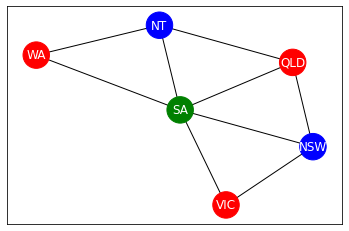

In [196]:
nx.draw_networkx(ng, node_color=colors, font_color="white", node_size=700)

In [197]:
sudoku = SudokuCSP()
sudoku.read_txt("sudoku.txt")

In [198]:
sudoku.show_board()

. . 3 | 7 . 6 | 9 . 5 
7 5 4 | 9 . 8 | 1 3 6 
. 9 . | 5 3 . | 4 . 7 
— — — — — — — — — — — 
5 2 . | . 6 . | 8 7 4 
8 . . | . 9 . | 3 . 2 
3 . 6 | . 7 2 | 5 1 9 
— — — — — — — — — — — 
. 3 5 | 6 1 7 | . 4 . 
2 . . | 3 . . | 7 9 1 
. . 7 | 2 . . | 6 5 3 


In [199]:
solver = BacktrackSolver(sudoku)
solver.solve()

True

In [200]:
sudoku.show_board()

1 8 3 | 7 4 6 | 9 2 5 
7 5 4 | 9 2 8 | 1 3 6 
6 9 2 | 5 3 1 | 4 8 7 
— — — — — — — — — — — 
5 2 9 | 1 6 3 | 8 7 4 
8 7 1 | 4 9 5 | 3 6 2 
3 4 6 | 8 7 2 | 5 1 9 
— — — — — — — — — — — 
9 3 5 | 6 1 7 | 2 4 8 
2 6 8 | 3 5 4 | 7 9 1 
4 1 7 | 2 8 9 | 6 5 3 
